In [2]:
import uproot
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse
from IPython.display import Markdown, display

import awkward as ak

import networkx as nx
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from pylab import cm
import glob
import tqdm
import argparse
import os.path as osp

import numpy as np
from sklearn.preprocessing import StandardScaler
import pickle
import awkward as ak

import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from numba import jit
import os, errno
import uproot as uproot
import glob
import time
import sys
from tqdm import tqdm


%matplotlib inline

In [41]:
def findNearestNeighbour(index, barycenters_x, barycenters_y, barycenters_z):
    # find nn, dist to nn for trackster i
    i_least = 0
    pos_i = np.array([barycenters_x[index], barycenters_y[index], barycenters_z[index]])
    d_least = 1000.
    for k in range(len(barycenters_x)):
        if k == index:
            continue
        pos_k = np.array([barycenters_x[k], barycenters_y[k], barycenters_z[k]])
        del_pos = pos_k - pos_i
        d = np.sqrt(del_pos[0]**2 + del_pos[1]**2 + del_pos[2]**2)
        if d < d_least:
            d_least = d
            i_least = k
    return i_least, d_least

def mkdir_p(mypath):
    '''Function to create a new directory, if it not already exist.
       Args:
           mypath : directory path
    '''
    from errno import EEXIST
    from os import makedirs, path
    try:
        makedirs(mypath)
    except OSError as exc:
        if not (exc.errno == EEXIST and path.isdir(mypath)):
            raise


In [53]:
def computeRatio(df1, df2):
    ratio = df1/ df2
    ratio_st = np.nan_to_num(np.sqrt((np.sqrt(df1)/df1)**2 + (np.sqrt(df2)/df2)**2))
    return ratio, ratio_st

def recomputeError(h1, h2, NBINS):
    h1.Sumw2()
    h2.Sumw2()
    ratio = h1.Clone('h3')
    ratio.Sumw2()
    ratio.Divide(h2)
    bin_errors = []
    for i in range(ratio.GetSize()):
        bin_errors.append(ratio.GetBinError(i))
    return bin_errors

def fixError(ratio, bin_errors):
    bin_errors_asym_neg = []
    bin_errors_asym_pos = []
    for i,e in enumerate(bin_errors[1:-1]):
        div = 1
        bin_errors_asym_neg.append(e/div)
        if(e/div + ratio[i] > 1):
            bin_errors_asym_pos.append(1-ratio[i])
        else:
            bin_errors_asym_pos.append(e/div)
    return [bin_errors_asym_neg, bin_errors_asym_pos]


In [49]:
def check_point_cone(h,base_radius,angle,start_point,x,y,z,eigenvector):
    test_point = np.array([x,y,z])
    base_radius = np.tan(angle)*h
    cone_dist = np.dot(test_point-start_point,eigenvector)
    cone_r = (cone_dist/h)*base_radius
    dist = np.linalg.norm((test_point-start_point)-cone_dist*eigenvector)
    return dist<cone_r

def connected_components(pairs):
    components = []

    for a, b in pairs:
        for component in components:
            if a in component:
                for i, other_component in enumerate(components):
                    if b in other_component and other_component != component: 
                        component.extend(other_component)
                        components[i:i+1] = []
                        break 
                else: 
                    if b not in component:
                        component.append(b)
                break 
            if b in component: 
                component.append(a)
                break 
        else: 
#             if components:
#                 if a or b in component:
#                     break
#             else:
            components.append([a, b])
        
       
    return components
def flatten_array(arr):
    flattened = []
    for item in arr:
        if isinstance(item, list):
            flattened.extend(flatten_array(item))
        else:
            flattened.append(item)
    return flattened
def order_pairs(pairs):
    sorted_pairs = sorted(pairs, key=lambda pair: (pair[1], pair[0]))
    return sorted_pairs

In [4]:
path = "/eos/cms/store/group/dpg_hgcal/comm_hgcal/wredjeb/TICLv4Sample/CMSSW_13_X/GNNTraining/CloseByPion0PU/ntuples_10_600/"
files = glob.glob(path + "*.root") 
trk_data_tot = []
gra_data_tot = []
ass_data_tot = []
lc_data_tot = []
simtrackstersSC_data_tot = []
simtrackstersCP_data_tot = []
for f in files:
    file = uproot.open(f)
    
    try:
        tracks = file["/ticlNtuplizer/tracks;1"]
        tracksters = file["ticlNtuplizer/tracksters;1"]
        simtracksters = file["ticlNtuplizer/simtrackstersSC;1"]
        simtrackstersCP = file["ticlNtuplizer/simtrackstersCP;1"]
        ass = file["ticlNtuplizer/associations;1"]
        gra = file["ticlNtuplizer/graph;1"]
        cand = file["ticlNtuplizer/candidates;1"]
        lc = file["ticlNtuplizer/clusters;1"]
        
    except Exception:
        continue
    trk_data = tracksters.arrays(["NTracksters", "raw_energy","raw_em_energy","barycenter_x","barycenter_y",
                              "barycenter_z","eVector0_x", "eVector0_y","eVector0_z","EV1","EV2","EV3",
                              "vertices_indexes", "sigmaPCA1", "sigmaPCA2", "sigmaPCA3", "vertices_x", "vertices_y",
                              "vertices_z", "vertices_energy", "layer_cluster_seed","trackster_barycenter_eta","trackster_barycenter_phi","raw_pt"])
    gra_data = gra.arrays(["linked_inners", "linked_outers"])
    # ass_data = ass.arrays(["tsCLUE3D_recoToSim_SC", "tsCLUE3D_recoToSim_SC_score",
    #                       "tsCLUE3D_simToReco_SC", "tsCLUE3D_simToReco_SC_score",
    #                        "tsCLUE3D_simToReco_SC_sharedE", "tsCLUE3D_recoToSim_SC_sharedE"])

    ass_data = ass.arrays([#'tsCLUE3D_recoToSim_PU', 'tsCLUE3D_recoToSim_PU_score', 'tsCLUE3D_recoToSim_PU_sharedE',
                                                          'tsCLUE3D_recoToSim_SC', 'tsCLUE3D_recoToSim_SC_score', 'tsCLUE3D_recoToSim_SC_sharedE', 'tsCLUE3D_simToReco_SC', 'tsCLUE3D_simToReco_SC_score', 
                                                          'tsCLUE3D_simToReco_SC_sharedE', 'tsCLUE3D_recoToSim_CP', 'tsCLUE3D_recoToSim_CP_score', 'tsCLUE3D_recoToSim_CP_sharedE', 'tsCLUE3D_simToReco_CP',
                                                          'tsCLUE3D_simToReco_CP_score', 'tsCLUE3D_simToReco_CP_sharedE',#'Mergetracksters_recoToSim_PU', #'Mergetracksters_recoToSim_PU_score'
    #                                                           'Mergetracksters_recoToSim_PU_sharedE', 'Mergetracksters_simToReco_PU', 'Mergetracksters_simToReco_PU_score', 'Mergetracksters_simToReco_PU_sharedE', 
                                                          'Mergetracksters_recoToSim_CP','Mergetracksters_recoToSim_CP_score','Mergetracksters_simToReco_CP', 'Mergetracksters_simToReco_CP_sharedE', 
                                                          'Mergetracksters_simToReco_CP_score'])

    cand_data = cand.arrays(["tracksters_in_candidate"])
    lc_data = lc.arrays(['position_x', 'position_y', 'position_z', 'energy','cluster_number_of_hits'])
    lc_data_tot.append(lc_data)
    ass_data_tot.append(ass_data)
    trk_data_tot.append(trk_data)
    gra_data_tot.append(gra_data)
    
    try:
        simtrackstersSC_data = simtracksters.arrays(["stsSC_raw_energy", 'stsSC_boundaryPx', 'stsSC_boundaryPy', 'stsSC_boundaryPz'])
        simtrackstersCP_data = simtrackstersCP.arrays(["stsCP_raw_energy", 'stsCP_boundaryPx', 'stsCP_boundaryPy', 'stsCP_boundaryPz',"trackster_barycenter_eta","trackster_barycenter_phi","raw_pt","vertices_indexes"])

    except Exception:
        simtrackstersSC_data = simtracksters.arrays(["raw_energy", 'boundaryPx', 'boundaryPy', 'boundaryPz','barycenter_x','NTracksters'])
        simtrackstersCP_data = simtrackstersCP.arrays(["raw_energy", 'boundaryPx', 'boundaryPy', 'boundaryPz','barycenter_x','NTracksters',"trackster_barycenter_eta","trackster_barycenter_phi","raw_pt","vertices_indexes"])
    simtrackstersCP_data_tot.append(simtrackstersCP_data)
    simtrackstersSC_data_tot.append(simtrackstersSC_data)

In [24]:
len(gra_data_tot[f])
gra_data_tot[f][0]

<Record ... [17, 16], [14, 17], [], [16]]} type='{"linked_inners": var * var * i...'>

In [45]:
edges_tot, edges_labels, edge_scores_1, edge_scores_2, simtrackstersSC_data, best_simTs_match = [],[],[],[],[],[]

In [57]:
edges_tot_cyl = []
score_threshold = .2
for f in range(len(trk_data_tot)):
    
    edges_ev = []
    for ev in range(len(trk_data_tot[f])):
        edges = []
        for i in range(trk_data_tot[f][ev].NTracksters):

          
            # For every linked (inner) trackster:
            for j in gra_data_tot[f][ev].linked_inners[i]:
                # Create an edge between the tracksters
                edges.append([j,i])
            #if (len(gra_data_tot[f][ev].linked_inners[i]) == 0 and len(gra_data_tot[f][ev].linked_outers[i]) == 0):
        #             if len(gra_data.linked_inners[i]) == 0 and len(gra_data.linked_outers[i]) == 0:
        #                 print(f"Trackster does not have any neighbours in the graph, connecting it to its nearest neighbour.")

                # this trackster does not have any neighbours in the graph, connect it to its nearest neighbour
#                 b_x = ak.to_numpy(trk_data_tot[f][ev].barycenter_x)
#                 b_y = ak.to_numpy(trk_data_tot[f][ev].barycenter_y)
#                 b_z = ak.to_numpy(trk_data_tot[f][ev].barycenter_z)
#                 nearest_id, nearest_dist = findNearestNeighbour(i, b_x, b_y, b_z)
#                 edges.append([i, nearest_id])
                
        edges_ev.append(edges)
    edges_tot_cyl.append(edges_ev)
        

In [58]:
threshold = .8
eta_num_fill = []
energy_num_fill = []
pt_num_fill = [] 
phi_num_fill = []
eta_den_fill = []
energy_den_fill = []
pt_den_fill = [] 
phi_den_fill = []
num = 0
den = 0

for f in range(len(trk_data_tot)):
    for ev in range(len(trk_data_tot[f])):
        simToRecoCP_indices = ass_data_tot[f].tsCLUE3D_simToReco_CP[ev]
        simToRecoCP_sharedFraction = ass_data_tot[f].tsCLUE3D_simToReco_CP_sharedE[ev]
        simToRecoCP_score = ass_data_tot[f].tsCLUE3D_simToReco_CP_score[ev]
        sim_energy = simtrackstersCP_data_tot[f].raw_energy[ev]
        sim_pt = simtrackstersCP_data_tot[f].raw_pt[ev]
        sim_phi = simtrackstersCP_data_tot[f].trackster_barycenter_phi[ev]
        sim_eta = simtrackstersCP_data_tot[f].trackster_barycenter_eta[ev]
        reco_energy = trk_data_tot[f].raw_energy[ev]
        reco_pt = trk_data_tot[f].raw_pt[ev]
        reco_phi = trk_data_tot[f].trackster_barycenter_phi[ev]
        reco_eta = trk_data_tot[f].trackster_barycenter_eta[ev]
        lc_en = lc_data_tot[f].energy[ev]
        lc_num_hits = lc_data_tot[f].cluster_number_of_hits[ev]
        sim_lc_indices = simtrackstersCP_data_tot[f].vertices_indexes[ev]
        

        tracksters_ev = trk_data_tot[f][ev]
        
        edges = edges_tot_cyl[f][ev]
        connected_edges = connected_components(order_pairs(edges))

        #print("edges")
       # print(edges)

        #for each simtrackster in the event
        reco_trk_energies = []
        reco_trk_indices = []
        efficiencies = []
        sim_track_energies = []
        sim_numerator = []
        sim_denominator = []
        for e in range(len(simToRecoCP_indices)):
            isMatched = False
            corrected_sim_energy = np.sum([lc_en[b] for b in  sim_lc_indices[e] if lc_num_hits[b]>1])
            num_lcs = [lc_en[b] for b in  sim_lc_indices[e] if lc_num_hits[b]>1]
            sim_track_energies.append(corrected_sim_energy)

            for r in range(len(connected_edges)):
                recoindices = [list(simToRecoCP_indices[e]).index(b) for b in connected_edges[r]]
                reco_trk_energies.append(np.sum(simToRecoCP_sharedFraction[0][recoindices]))
                efficiency = np.sum(simToRecoCP_sharedFraction[0][recoindices])/corrected_sim_energy
               # print("ratio of passed LCs vs total", len(num_lcs)/len(sim_lc_indices[e]))
               # efficiencycorrected = np.sum(simToRecoCP_sharedFraction[0][recoindices])/np.sum(reco_energy[recoindices])
                #efficiency_sim = np.sum(simToRecoCP_sharedFraction[0][recoindices])/sim_energy[e]
               # print("efficiency",efficiency, "corr", efficiencycorrected,"sim",efficiency_sim)

               # if f<2 and ev<10:
               # print(corrected_sim_energy,"  ",np.sum(reco_energy[recoindices]))
                sim_denominator.append([sim_energy[e],sim_pt[e],sim_phi[e],sim_eta[e]])
                if efficiency>threshold:
                    num+=1
                    isMatched= True
                    sim_numerator.append([sim_energy[e],sim_pt[e],sim_phi[e],sim_eta[e]])
                    if sim_pt[e]>10.:
                        eta_num_fill.append(sim_numerator[e][3])
                    phi_num_fill.append(sim_numerator[e][2])
                    energy_num_fill.append(sim_numerator[e][0])
                    pt_num_fill.append(sim_numerator[e][1])
                if sim_pt[e]>10:
                    eta_den_fill.append(sim_denominator[e][3])
                phi_den_fill.append(sim_denominator[e][2])
                energy_den_fill.append(sim_denominator[e][0])
                pt_den_fill.append(sim_denominator[e][1])
                den+=1
print(num/den)
#given reconstruction that we have, want to quantify
#sum of shared_energy
#sum of the shared fractions of the recotracksters
#sum of the energies of the recotracksters that are connected
#sum of these energies
#of simtracksters #number of reconstrcuted simtracksters
#goes up by one when #event
#numerator is how many times we actually get this property\
#creat a self edge between all ndes
# edge
# given a graph, also compute energy that shouldn't o
#maximize efficiency minimize contamination


0.9086315789473685


In [59]:
NBINS = 10
NBINSPT = 10
NBINSPHI = 10
NBINSETA = 10
e_N, bins_e = np.histogram(energy_num_fill, bins = NBINS, range = (min(energy_den_fill), max(energy_den_fill)))
e_D, bins_e = np.histogram(energy_den_fill, bins = NBINS, range = (min(energy_den_fill), max(energy_den_fill)))
pt_N, bins_pt = np.histogram(pt_num_fill, bins = NBINSPT, range = (min(pt_den_fill),max(pt_den_fill)))
pt_D, bins_pt = np.histogram(pt_den_fill, bins = NBINSPT, range = (min(pt_den_fill), max(pt_den_fill)))
phi_N, bins_phi = np.histogram(phi_num_fill, bins = NBINSPHI, range = (min(phi_den_fill),max(phi_den_fill)))
phi_D, bins_phi = np.histogram(phi_den_fill, bins = NBINSPHI, range = (min(phi_den_fill), max(phi_den_fill)))
eta_N, bins_eta = np.histogram(eta_num_fill, bins = NBINSETA, range = (min(eta_den_fill),max(eta_den_fill)))
eta_D, bins_eta = np.histogram(eta_den_fill, bins = NBINSETA, range = (min(eta_den_fill), max(eta_den_fill)))

In [60]:
ratioE, stdE = computeRatio(e_N,e_D)
#errorsE = fixError(ratioE, bin_errorsE)
ratioPt, stdPt = computeRatio(pt_N,pt_D)
#errorsPt = fixError(ratioPt, bin_errorsPt)
ratioEta, stdEta = computeRatio(eta_N,eta_D)
#errorsEta = fixError(ratioEta, bin_errorsEta)
ratioPhi, stdPhi = computeRatio(phi_N,phi_D)
#errorsPhi = fixError(ratioPhi, bin_errorsPhi)


/tmp/ipykernel_707/48829472.py:3: RuntimeWarning: invalid value encountered in true_divide
  ratio_st = np.nan_to_num(np.sqrt((np.sqrt(df1)/df1)**2 + (np.sqrt(df2)/df2)**2))


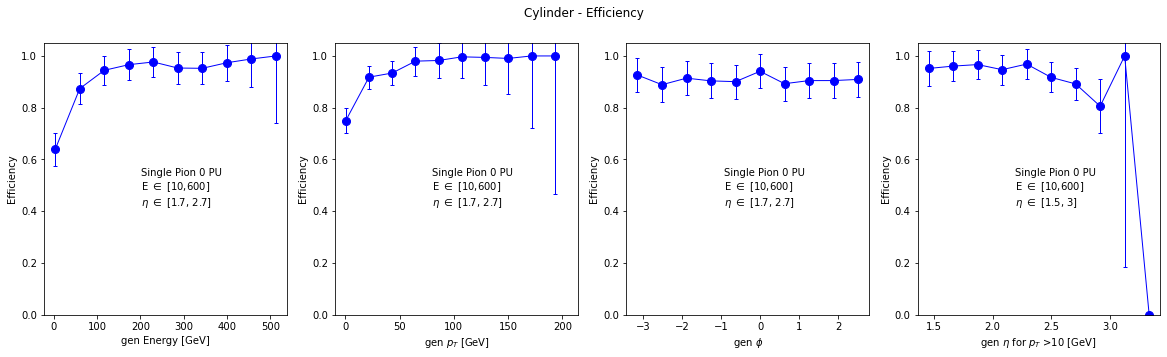

In [61]:
plt.figure(figsize = (20,5))
i_c = 0
col = 'blue'
Particle = "Pion"
PU = 0
c = .8
plt.subplot(1,4,1)
plt.errorbar(bins_e[:-1], ratioE, yerr=stdE, linestyle = None, marker = 'o', lw = 1, label = f"Shared Fraction Threshold {c}", capsize = 2, c =  col, markersize = 8)
# plt.errorbar(bins_e3[:-1], ratioE3, yerr=stdE3, linestyle = None, marker = 'o', lw = 1, label = 'TICLv3', capsize = 2)
plt.ylim(0,1.05)
if(i_c == 0):
    plt.suptitle("TracksterMerge - Efficiency ")
    plt.xlabel("gen Energy [GeV]")
    plt.ylabel("Efficiency")
    plt.annotate(f"Single {Particle} {PU} PU\nE $\in$ [10,600]\n$\eta$ $\in$ [1.7, 2.7]", xy = (0.4,0.4), xycoords='axes fraction')
    #hep.cms.text('Simulation')

plt.subplot(1,4,2)
plt.errorbar(bins_pt[:-1], ratioPt, yerr=stdPt, linestyle = None, marker = 'o', lw = 1, label = f"Shared Fraction Threshold {c}", capsize = 2, c = col, markersize = 8)
# plt.errorbar(bins_e3[:-1], ratioE3, yerr=stdE3, linestyle = None, marker = 'o', lw = 1, label = 'TICLv3', capsize = 2)
plt.ylim(0,1.05)
if(i_c == 0):
    plt.suptitle("TracksterMerge - Efficiency ")
    plt.xlabel("gen $p_{T}$ [GeV]")
    plt.ylabel("Efficiency")
    plt.annotate(f"Single {Particle} {PU} PU\nE $\in$ [10,600]\n$\eta$ $\in$ [1.7, 2.7]", xy = (0.4,0.4), xycoords='axes fraction')
    #hep.cms.text('Simulation')
plt.xlim(None, np.max(pt_den_fill))
plt.subplot(1,4,3)
plt.errorbar(bins_phi[:-1], ratioPhi, yerr=stdPhi, linestyle = None, marker = 'o', lw = 1, label = f"Shared Fraction Threshold {c}", capsize = 2, c = col, markersize = 8)
# plt.errorbar(bins_e3[:-1], ratioE3, yerr=stdE3, linestyle = None, marker = 'o', lw = 1, label = 'TICLv3', capsize = 2)
plt.ylim(0,1.05)
if(i_c == 0):
    plt.suptitle("TracksterMerge - Efficiency ")
    plt.xlabel("gen $\phi$")
    plt.ylabel("Efficiency")
    plt.annotate(f"Single {Particle} {PU} PU\nE $\in$ [10,600]\n$\eta$ $\in$ [1.7, 2.7]", xy = (0.4,0.4), xycoords='axes fraction')
    #hep.cms.text('Simulation')
plt.subplot(1,4,4)
plt.errorbar(bins_eta[:-1], ratioEta, yerr=stdEta, linestyle = None, marker = 'o', lw = 1, label = f"Shared Fraction Threshold {c}", capsize = 2, c = col, markersize = 8)
# plt.errorbar(bins_e3[:-1], ratioE3, yerr=stdE3, linestyle = None, marker = 'o', lw = 1, label = 'TICLv3', capsize = 2)
plt.ylim(0,1.05)
if(i_c == 0):
    plt.suptitle(f"Cylinder - Efficiency")
    plt.xlabel("gen $\eta$ for $p_{T}$ >10 [GeV] ")
    plt.ylabel("Efficiency")
    plt.annotate(f"Single {Particle} {PU} PU\nE $\in$ [10,600]\n$\eta$ $\in$ [1.5, 3]", xy = (0.4,0.4), xycoords='axes fraction')
    #hep.cms.text('Simulation')
